In [66]:
root_dir = "../../Downloads/GENOME540/"

pyogenes_path = root_dir + "s_pyogenes.gbff"
test1_path = root_dir + "test1.gbff"
test2_path = root_dir + "test2.gbff"

path = pyogenes_path

In [67]:
def get_sequence(file_path):

  gb = open(file_path, "r").read()
  
  seq = ""
  for char in gb[gb.find("ORIGIN")+6:]:
    if char in ["a", "c", "g", "t", "n"]:
      seq += char.upper()

  return seq

seq = get_sequence(path)
print(len(seq))

1746380


In [68]:
from collections import Counter

def nucleotide_histogram(sequence):

    print("Nucleotide Histogram:")

    nucleotides = Counter(sequence)

    for nucleo in ["A", "C", "G", "T", "N"]:
        print(nucleo + "=" + str(nucleotides[nucleo]))

nucleotide_histogram(seq)

Nucleotide Histogram:
A=537381
C=334523
G=338691
T=535785
N=0


In [69]:
def get_background_frequency(sequence):

    print("Background Frequency:")

    nucleotides = {"A": 0, "C": 0, "G": 0, "T": 0}
    complement = {"A": "T", "C": "G", "G": "C", "T": "A"}

    total = 0
    for i in range(len(sequence)-21):

        s = sequence[i:i+21]

        for char in s:
            if char in nucleotides:
                nucleotides[char] += 1
                nucleotides[complement[char]] += 1
                total += 2

    for nucleo in nucleotides:
        freq = nucleotides[nucleo] / total
        print(nucleo + "=" + f'{freq:.4f}')

get_background_frequency(seq)

Background Frequency:
A=0.3073
C=0.1927
G=0.1927
T=0.3073


In [70]:
import pandas as pd

def get_sites(file_path):

    df = pd.DataFrame(columns=["coord", "compl", "join"])
    df[["compl", "join"]] = df[["compl", "join"]].astype(bool)
    complement = {"A": "T", "C": "G", "G": "C", "T": "A", "N": "N"}

    with open(file_path, 'r') as f:
        lines = [line.rstrip('\n') for line in f]

    for line_num in range(len(lines)):

        if 'CDS ' in lines[line_num] and "<" not in lines[line_num] and ">" not in lines[line_num]:

            coord_line = lines[line_num].strip().split()[1]
            compl = "complement" in coord_line
            join = "join" in coord_line
            dead_line = False

            if join:
                i = 0
                while(lines[line_num + i][-1] == ","):
                    i += 1
                    next_line = lines[line_num + i].strip()
                    if  "<"  in next_line or ">" in next_line:
                        dead_line = True
                    coord_line += next_line

            if coord_line[:3] == "1..":
                dead_line = True

            if dead_line:
                continue

            coords = coord_line.replace("complement", "").replace("join", "").replace("(", "").replace(")", "").split(",")

            coordz = []
            for coord_pair in coords:
                coordz.append(tuple([(int(x)-1) for x in coord_pair.split("..")]))
            
            df = pd.concat([df, pd.DataFrame({"coord": [coordz], "compl": compl, "join": join})], ignore_index=True)

    return df

cds_sites = get_sites(path)
cds_sites.head()

,coord,compl,join
0,"[(1511, 2647)]",False,False
1,"[(2722, 2919)]",False,False
2,"[(3249, 4364)]",False,False
3,"[(4434, 5003)]",False,False
4,"[(5006, 8509)]",False,False


In [71]:
def get_cds_sequence(sequence, df):

    complement = {"A": "T", "C": "G", "G": "C", "T": "A", "N": "N"}

    cds_starts0 = []
    cds_starts1 = []
    for row in df.itertuples():

        compl = row.compl
        join = row.join
        coords = row.coord

        cds_start0 = []
        cds_start1 = []
        for coord_pair in coords:
            cds_start0.append(coord_pair[0])
            cds_start1.append(len(sequence) - coord_pair[1])

        cds_seq = ""
        if not compl and not join:
            cds_seq = sequence[coords[0][0]-10: coords[0][1]+11]

        elif not compl and join:

            cds_seq += sequence[coords[0][0]-10: coords[0][0]]

            for coord_pair in coords:
                cds_seq += sequence[coord_pair[0]: coord_pair[1]+1]

            if len(cds_seq) < 21:
                cds_seq += sequence[coords[-1][1]: coords[-1][1]+21-len(cds_seq)]

        elif compl and not join:

            for coord in range(coords[0][1]+10, coords[0][1], -1):
                cds_seq += complement[sequence[coord]]
            for coord in range(coords[0][1], coords[0][1]-11, -1):
                cds_seq += complement[sequence[coord]]

        elif compl and join:

            for coord in range(coords[-1][1]+10, coords[-1][1], -1):
                cds_seq += complement[sequence[coord]]

            for coord_pair in coords[::-1]:
                for coord in range(coord_pair[1], coord_pair[0]-1, -1):
                    cds_seq += complement[sequence[coord]]

            if len(cds_seq) < 21:
                for coord in range(coords[0][0], coords[0][0]-(22-len(cds_seq)), -1):
                    cds_seq += complement[sequence[coord]]
            
        cds_seq = cds_seq[:21]
        assert len(cds_seq) == 21
        df.at[row.Index, "cds_seq"] = cds_seq

        cds_starts0.append(cds_start0)
        cds_starts1.append(cds_start1)

    df["cds_start0"] = cds_starts0
    df["cds_start1"] = cds_starts1

    return df

cds_sites = get_cds_sequence(seq, cds_sites)
sites = cds_sites.cds_seq.tolist()
cds_sites.head()

,coord,compl,join,cds_seq,cds_start0,cds_start1
0,"[(1511, 2647)]",False,False,AGGAGTTCTCATGATTCAATT,[1511],[1743733]
1,"[(2722, 2919)]",False,False,AGAAAAGGGAATGTATCAAAT,[2722],[1743461]
2,"[(3249, 4364)]",False,False,GATTCGCTAAATGGCTTTAAC,[3249],[1742016]
3,"[(4434, 5003)]",False,False,AAGAGAAAATATGGTAAAAAT,[4434],[1741377]
4,"[(5006, 8509)]",False,False,ATGGATAATCATGGATATTTT,[5006],[1737871]


In [72]:
import numpy as np

def get_site_count_matrix(sitez):

    print("Count Matrix:")

    nucleotides = {"A": 0, "C": 1, "G": 2, "T": 3}
    count_matrix = np.zeros((21, 4))
    
    for site in sitez:
        for i in range(len(site)):
            base = site[i]
            if base != "N":
                count_matrix[i][nucleotides[base]] += 1

    for i in range(len(count_matrix)):
        print(i-10, ' '.join(str(int(x)) for x in count_matrix[i]))

    return count_matrix

count_mat = get_site_count_matrix(sites)

Count Matrix:
-10 602 53 777 188
-9 546 73 793 208
-8 606 71 688 255
-7 633 134 487 366
-6 637 129 397 457
-5 747 167 267 439
-4 702 189 209 520
-3 708 286 305 321
-2 638 255 209 518
-1 542 320 215 543
0 1478 1 73 68
1 0 0 0 1620
2 5 2 1612 1
3 861 133 377 249
4 560 572 141 347
5 828 125 130 537
6 813 216 306 285
7 805 240 149 426
8 744 148 179 549
9 705 253 303 359
10 619 268 177 556


In [73]:
def get_site_frequency_matrix(count_matrix):

    print("Frequency Matrix:")

    frequency_matrix = []
    for i in range(len(count_matrix)):
        frequency_matrix.append(count_matrix[i] / sum(count_matrix[i]))
    frequency_matrix = np.array(frequency_matrix)

    for i in range(len(count_matrix)):
        print(i-10, ' '.join(f'{x:.4f}' for x in frequency_matrix[i]))

    return frequency_matrix

freq_mat = get_site_frequency_matrix(count_mat)

Frequency Matrix:
-10 0.3716 0.0327 0.4796 0.1160
-9 0.3370 0.0451 0.4895 0.1284
-8 0.3741 0.0438 0.4247 0.1574
-7 0.3907 0.0827 0.3006 0.2259
-6 0.3932 0.0796 0.2451 0.2821
-5 0.4611 0.1031 0.1648 0.2710
-4 0.4333 0.1167 0.1290 0.3210
-3 0.4370 0.1765 0.1883 0.1981
-2 0.3938 0.1574 0.1290 0.3198
-1 0.3346 0.1975 0.1327 0.3352
0 0.9123 0.0006 0.0451 0.0420
1 0.0000 0.0000 0.0000 1.0000
2 0.0031 0.0012 0.9951 0.0006
3 0.5315 0.0821 0.2327 0.1537
4 0.3457 0.3531 0.0870 0.2142
5 0.5111 0.0772 0.0802 0.3315
6 0.5019 0.1333 0.1889 0.1759
7 0.4969 0.1481 0.0920 0.2630
8 0.4593 0.0914 0.1105 0.3389
9 0.4352 0.1562 0.1870 0.2216
10 0.3821 0.1654 0.1093 0.3432


In [74]:
def get_reverse_complement(sequence):

    complement = {"A": "T", "C": "G", "G": "C", "T": "A", "N": "N"}
    return "".join([complement[base] for base in sequence[::-1]])

In [75]:
def get_background_count_matrix(sequence):

    nucleotides = {"A": 0, "C": 1, "G": 2, "T": 3}
    complements = {"A": "T", "C": "G", "G": "C", "T": "A"}
    count_matrix = np.zeros((21, 4))

    sequence_reverse_compl = get_reverse_complement(sequence)
    for i in range(len(sequence)-21):

        s = sequence[i:i+21]
        rev_compl = sequence_reverse_compl[i:i+21]
    
        for j in range(len(s)):
            base = s[j]
            if base != "N":
                count_matrix[j][nucleotides[base]] += 1

            base = rev_compl[j]
            if base != "N":
                count_matrix[j][nucleotides[base]] += 1

    return count_matrix

def get_background_frequency_matrix(sequence):

    count_matrix = get_background_count_matrix(sequence)

    frequency_matrix = []
    for i in range(len(count_matrix)):
        frequency_matrix.append(count_matrix[i] / sum(count_matrix[i]))
    frequency_matrix = np.array(frequency_matrix)

    return frequency_matrix

background_freq_mat = get_background_frequency_matrix(seq)

In [76]:
def get_weight_matrix(frequency_matrix, background_frequency_matrix):

    print("Weight Matrix:")

    weight_matrix = frequency_matrix / background_frequency_matrix

    weight_matrix = np.log2(weight_matrix, out=np.zeros_like(weight_matrix), where=(weight_matrix!=0))
    weight_matrix[weight_matrix == 0] = -99

    for i in range(len(weight_matrix)):
        print(i-10, ' '.join(f'{x:.4f}' for x in weight_matrix[i]))

    return weight_matrix

weight_mat = get_weight_matrix(freq_mat, background_freq_mat)

Weight Matrix:
-10 0.2743 -2.5586 1.3152 -1.4047
-9 0.1335 -2.0967 1.3446 -1.2588
-8 0.2839 -2.1368 1.1397 -0.9649
-7 0.3468 -1.2205 0.6412 -0.4436
-6 0.3559 -1.2753 0.3464 -0.1232
-5 0.5857 -0.9028 -0.2259 -0.1812
-4 0.4960 -0.7243 -0.5792 0.0631
-3 0.5083 -0.1267 -0.0339 -0.6329
-2 0.3581 -0.2922 -0.5792 0.0575
-1 0.1229 0.0354 -0.5384 0.1255
0 1.5701 -8.2865 -2.0967 -2.8718
1 -99.0000 -99.0000 -99.0000 1.7025
2 -6.6374 -7.2865 2.3681 -8.9593
3 0.7906 -1.2313 0.2719 -0.9993
4 0.1700 0.8733 -1.1470 -0.5205
5 0.7342 -1.3208 -1.2642 0.1095
6 0.7078 -0.5317 -0.0292 -0.8045
7 0.6936 -0.3797 -1.0674 -0.2246
8 0.5799 -1.0771 -0.8027 0.1414
9 0.5022 -0.3036 -0.0434 -0.4714
10 0.3145 -0.2205 -0.8189 0.1597


In [77]:
def get_max_score():

    maxx = 0
    idxs = []
    for scores in weight_mat:
        idx = np.argmax(scores)
        idxs.append(idx)
        maxx += scores[idx]

    print("Maximum Score:", maxx)

    return idxs

max_idxs = get_max_score()

Maximum Score: 17.707171292967562


In [78]:
def score(twenty_one, weight_matrix):

    assert len(twenty_one) == 21

    nucleotides = {"A": 0, "C": 1, "G": 2, "T": 3}

    score = 0
    for i in range(len(twenty_one)):
        base = twenty_one[i]
        if base == "N":
            continue
        score += weight_matrix[i][nucleotides[base]]

    return score

In [79]:
def histogram(data):
    histogram = {}
    for value in data:
        if value < -50:
            bin = "lt-50"
        else:
            bin = int(value)
        if bin not in histogram:
            histogram[bin] = 0
        histogram[bin] += 1
    return dict(sorted(histogram.items(), key=lambda x: (x[0] == "lt-50", x[0])))

def get_site_scores(sitez, weight_matrix):

    scores = []
    for site in sitez:
        scores.append(score(site, weight_matrix))

    print("Score Histogram CDS:")
    hist = histogram(scores)
    for i in hist:
        print(i, hist[i])
    
    return scores

site_scores = get_site_scores(sites, weight_mat)

Score Histogram CDS:
-9 2
-8 1
-7 1
-4 4
-3 3
-2 8
-1 13
0 34
1 24
2 37
3 67
4 86
5 112
6 139
7 167
8 193
9 196
10 198
11 167
12 86
13 56
14 20
15 6


In [58]:
def get_background_scores(sequence, weight_matrix):

    scores = []
    for i in range(len(sequence)-21):
        scores.append(score(sequence[i:i+21], weight_matrix))
        scores.append(score(get_reverse_complement(sequence[i:i+21]), weight_matrix))

    print("Score Histogram All:")
    hist = histogram(scores)
    for i in hist:
        print(i, hist[i])

    return scores

background_scores = get_background_scores(seq, weight_mat)

Score Histogram All:
-6 1
-5 3
-4 41
-3 325
-2 870
-1 2309
0 12183
1 11173
2 13572
3 15282
4 15946
5 14365
6 12238
7 9108
8 6079
9 3254
10 1559
11 671
12 198
13 32
14 8
lt-50 5671951


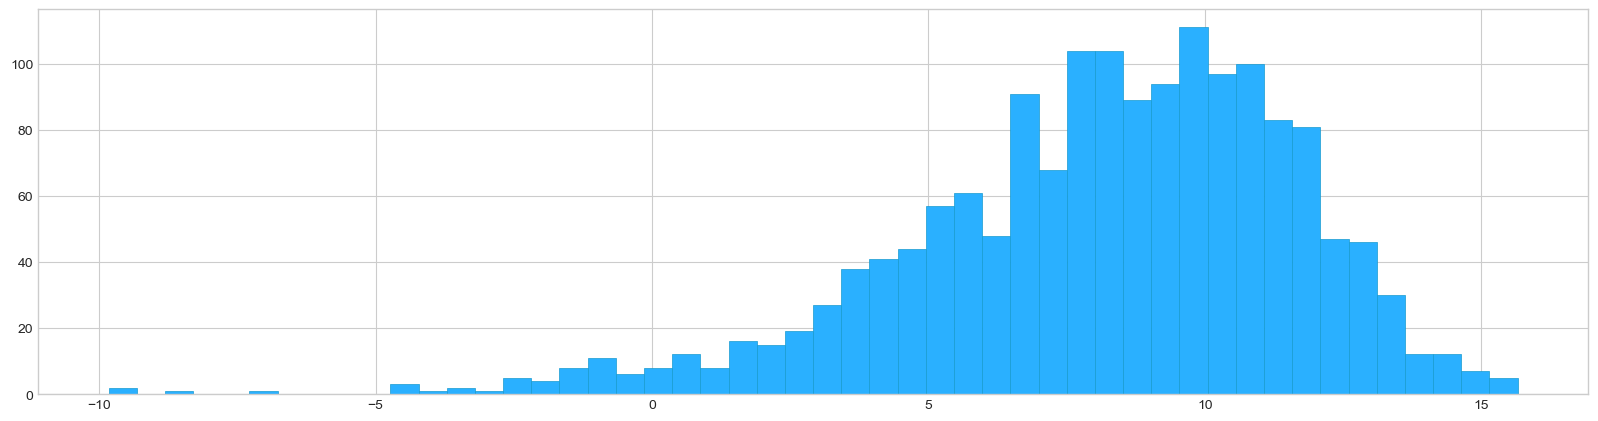

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.style.use('seaborn-v0_8-whitegrid')
plt.hist(site_scores, bins=50, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()

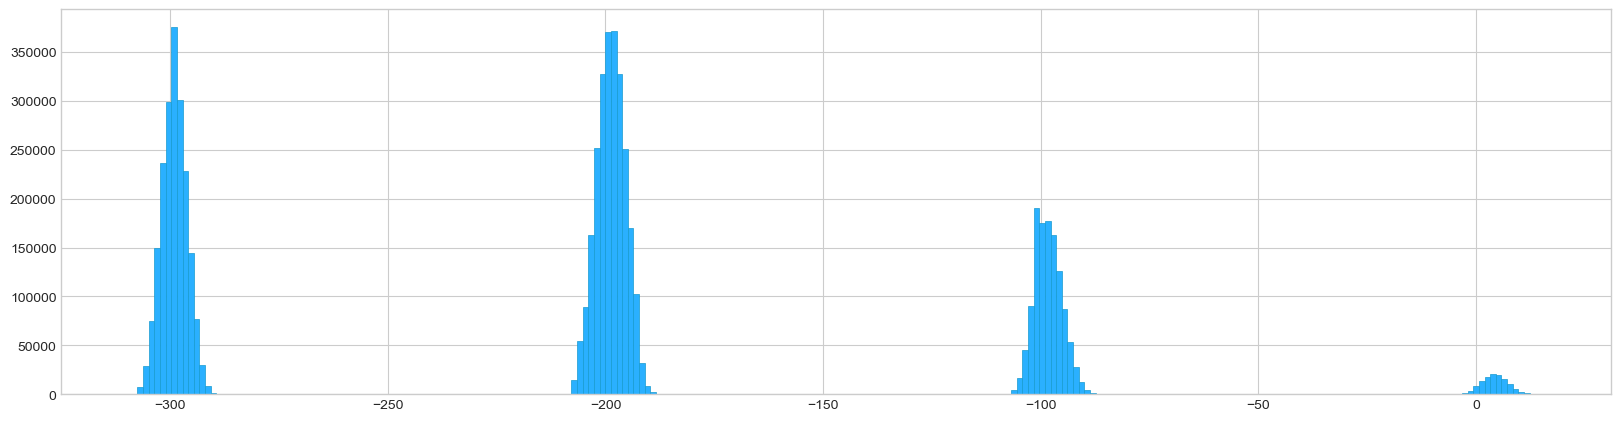

In [81]:
plt.figure(figsize=(20, 5))
plt.style.use('seaborn-v0_8-whitegrid')
plt.hist(background_scores, bins=250, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()

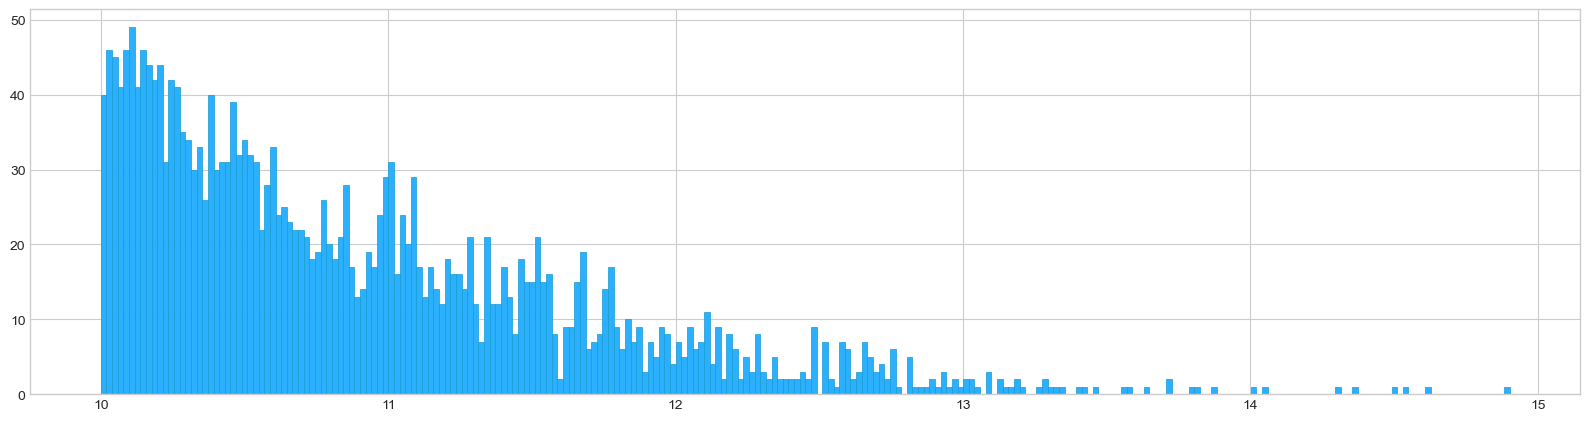

In [82]:
plt.figure(figsize=(20, 5))
plt.style.use('seaborn-v0_8-whitegrid')
plt.hist([x for x in background_scores if x > 10], bins=250, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()

In [ ]:
import itertools

def get_position_list(sequence, cds_starts0, cds_starts1, weight_matrix):

    position_list = []
    for i in range(len(sequence)-21):

        if i+11 not in cds_starts0:
            s = sequence[i:i+21]
            scoree = score(s, weight_matrix)
            if scoree >= 10:
                position_list.append((i, 0, scoree))

    rev_compl = get_reverse_complement(sequence)
    for i in range(len(rev_compl)-21):

        if i+11 not in cds_starts1:
            s = rev_compl[i:i+21]
            scoree = score(s, weight_matrix)
            if scoree >= 10:
                position_list.append((i, 1, scoree))

    position_list = sorted(position_list, key=lambda x: x[0])

    print("Position List:")
    for pos in position_list:
        print(pos[0]+11, pos[1], pos[2])

    return position_list

pos_arr = get_position_list(seq, list(itertools.chain.from_iterable(cds_sites["cds_start0"])), list(itertools.chain.from_iterable(cds_sites["cds_start1"])), weight_mat)